### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


VERBOSE = 1
CV = [(slice(None), slice(None))]
TESTING = False

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-19 16:50:34.403645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 16:50:35.522126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 3

hyperparameterspace = {
    'epochs': ["interval-int", 1, 30],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01],
    'model__neurons_per_layer': ["interval-int", 1, 100],
    'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233214, 233211, 359935, 359952, 359940, 359931]#, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(neurons_per_layer=20, number_of_layers=1): 
        # create model
        model = Sequential()
        model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
        for _ in range(number_of_layers):
            model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = int(params[3])

        number_of_layers = int(params[4])

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
            K.clear_session()
            return result 
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
            K.clear_session()
            return result
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                for _ in range(number_of_layers):
                    model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
                model.add(Dense(1, activation=None))
                # Compile model
                
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
                K.clear_session()
                return result
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
                K.clear_session()
                return result
            


    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1)*len(hyperparameterspace.keys())
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = i

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " + str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        TESTING = True
        BAYESIAN_RESULT.append(-blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(BUDGET)
        SPARSE_COST_OPTIMIZED.append(BUDGET)

        K.clear_session()
    


######################################################################################################################################################
Current Dataset: 1 of 6 with id: 233214

################################################## Current Budget: 5 ##################################################
Performing grid search
Fitting 1 folds for each of 1 candidates, totalling 1 fits


2023-04-19 16:50:43.865570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Best params found by grid search:
{'batch_size': 105, 'epochs': 15, 'model__neurons_per_layer': 50, 'model__number_of_layers': 5, 'optimizer__learning_rate': 3.16227766016838e-05}
Performing random search
Fitting 1 folds for each of 5 candidates, totalling 5 fits
Best params found by random search:
{'batch_size': 180, 'epochs': 28, 'model__neurons_per_layer': 22, 'model__number_of_layers': 7, 'optimizer__learning_rate': 4.831855366313453e-07}
Performing bayesian optimization
Iterations took 27.80922432799707 seconds
With Hyperparameters: 
epochs: 15.447174718699214
batch_size: 102.32691642463745
optimizer__learning_rate: 0.009498537282635642
model__neurons_per_layer: 22.13390767343499
model__number_of_layers: 7.157518820320308
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 370626ms.
Solving linear system (automatic method)...
Done in 3ms.

Optimal hyperparameters so far:
epochs: 15.5
batch_size: 105.0
optimizer__learning_rate: 3.1622776601683795e-05
model__

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 108.09830298999441 seconds
With Hyperparameters: 
epochs: 1.0
batch_size: 63.93748080609742
optimizer__learning_rate: 0.0034136684039950543
model__neurons_per_layer: 21.859006798895454
model__number_of_layers: 4.027589066140761
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 372901ms.
Solving linear system (automatic method)...
Done in 6ms.

Optimal hyperparameters so far:
epochs: 15.5
batch_size: 152.5
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 50.5
model__number_of_layers: 7.75
Resulting loss:
0.7951463767665016
Optimizing (gradient descent)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 29.999992008100275
batch_size: 199.99989422012902
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 66.11624224465511
model__number_of_layers: 9.99999599079715
Resulting loss (Optimal value from optimization):
-0.37139456492228284
Resulting loss (Optimal point evaluated):
0.92390

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 118.76723800599575 seconds
With Hyperparameters: 
epochs: 6.103746562954004
batch_size: 175.89203873859265
optimizer__learning_rate: 0.0008190905895119261
model__neurons_per_layer: 32.598107317187115
model__number_of_layers: 3.737333210553392
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 1085181ms.
Solving linear system (automatic method)...
Done in 4ms.

Optimal hyperparameters so far:
epochs: 22.75
batch_size: 105.0
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.01881253546472403
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 29.99998216962304
batch_size: 199.99990519475313
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 1.0000793453445087
model__number_of_layers: 9.99999718720293
Resulting loss (Optimal value from optimization):
-0.3282194898008982
Resulting loss (Optimal point evalu

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 384.34135198600416 seconds
With Hyperparameters: 
epochs: 27.454084676708316
batch_size: 71.15909634073057
optimizer__learning_rate: 0.009799834622805778
model__neurons_per_layer: 9.52573290679915
model__number_of_layers: 7.918032237579092
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 1189252ms.
Solving linear system (automatic method)...
Done in 9ms.

Optimal hyperparameters so far:
epochs: 15.5
batch_size: 105.0
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 50.5
model__number_of_layers: 3.25
Resulting loss:
0.018974812375764115
Optimizing (gradient descent)...
Done in 2ms.

Optimal hyperparameters after optimization:
epochs: 29.999983218410396
batch_size: 10.00015211913589
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 99.9999274292005
model__number_of_layers: 9.999995309259376
Resulting loss (Optimal value from optimization):
-0.7337901773434474
Resulting loss (Optimal point evaluate

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 22.74213642500399 seconds
With Hyperparameters: 
epochs: 23.27225603098864
batch_size: 120.17008342173364
optimizer__learning_rate: 0.008177604077347224
model__neurons_per_layer: 18.482388004566875
model__number_of_layers: 8.140063897279727
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 242253ms.
Solving linear system (automatic method)...
Done in 7ms.

Optimal hyperparameters so far:
epochs: 22.75
batch_size: 105.0
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.597313540753026
Optimizing (gradient descent)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 29.999983257474668
batch_size: 105.00003746556106
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 1.0000614766040512
model__number_of_layers: 1.0000015862880594
Resulting loss (Optimal value from optimization):
-0.6807563223231706
Resulting loss (Optimal point evaluat

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 72.95704700100032 seconds
With Hyperparameters: 
epochs: 12.521113890317942
batch_size: 137.30564584374775
optimizer__learning_rate: 0.007021298605026479
model__neurons_per_layer: 93.35399074982297
model__number_of_layers: 8.87684577363993
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 231148ms.
Solving linear system (automatic method)...
Done in 6ms.

Optimal hyperparameters so far:
epochs: 15.5
batch_size: 105.0
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 75.25
model__number_of_layers: 5.5
Resulting loss:
0.6150992169017226
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
batch_size: 105.0
optimizer__learning_rate: 0.0005623413251903491
model__neurons_per_layer: 75.25
model__number_of_layers: 5.5
Resulting loss (Optimal value from optimization):
0.6150992169017226
Resulting loss (Optimal point evaluated):
0.621089686367059
#################################

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 87.79381594499137 seconds
With Hyperparameters: 
epochs: 15.417484749851432
batch_size: 116.2002298421731
optimizer__learning_rate: 0.008098211637856165
model__neurons_per_layer: 42.648810524089846
model__number_of_layers: 3.6654129497474877
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 301259ms.
Solving linear system (automatic method)...
Done in 5ms.

Optimal hyperparameters so far:
epochs: 22.75
batch_size: 105.0
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
1.5768110449055555
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 22.75
batch_size: 105.0
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss (Optimal value from optimization):
1.5768110449055555
Resulting loss (Optimal point evaluated):
1.581014330087973

############################

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 144.3187901769852 seconds
With Hyperparameters: 
epochs: 29.764788404609423
batch_size: 109.77548826530838
optimizer__learning_rate: 0.0059080761522190064
model__neurons_per_layer: 30.340406933183424
model__number_of_layers: 2.597951765864904
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 292206ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 15.5
batch_size: 57.5
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 50.5
model__number_of_layers: 7.75
Resulting loss:
1.5725344384883186
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.0000086252090787
batch_size: 10.000032987436171
optimizer__learning_rate: 3.1622776601683795e-05
model__neurons_per_layer: 1.0000832402001527
model__number_of_layers: 1.0000032166708248
Resulting loss (Optimal value from optimization):
-0.9494675298100591
Resulting loss (Optimal point eva

[1.2468328, 1.1539297, 1.1430688, 0.02299372, 0.024930079, 0.036764212, 0.66836995, 0.6441541, 0.6111407, 0.463761, 0.45746827, 0.47775263, 1.1346432, 1.0517157, 1.0228572, 0.94943213, 0.8880475, 0.7634813]
[1.3212092, 1.1137103, 1.1446553, 0.025106888, 0.023401784, 0.029648105, 0.60778666, 0.69196, 0.6604785, 0.46940947, 0.49085906, 0.4517583, 1.0388714, 1.0317041, 1.2823093, 0.9484458, 0.87863845, 0.8313203]
[1.2359283, 0.8398411, 1.1296914, 0.065747805, 0.027185505, 0.027526641, 0.65290105, 0.6861631, 0.6438442, 0.48921657, 0.4877624, 0.4676155, 0.79928726, 0.93294054, 1.0183247, 0.9997063, 0.858962, 0.8984517]
[0.8465347872710859, 0.8488993614967258, 0.8448701103159821, 0.029134447697827387, 0.026569125240262774, 0.02400100617858161, 0.6379709197959288, 0.6727240204579079, 0.6652665814560377, 0.4759696683873266, 0.5016019131274717, 0.46221093977336897, 0.820013549531737, 0.8243763265228605, 0.8308958909728883, 0.8058470795150541, 1.0559446925293885, 0.8170318743564393]
[0.900101685

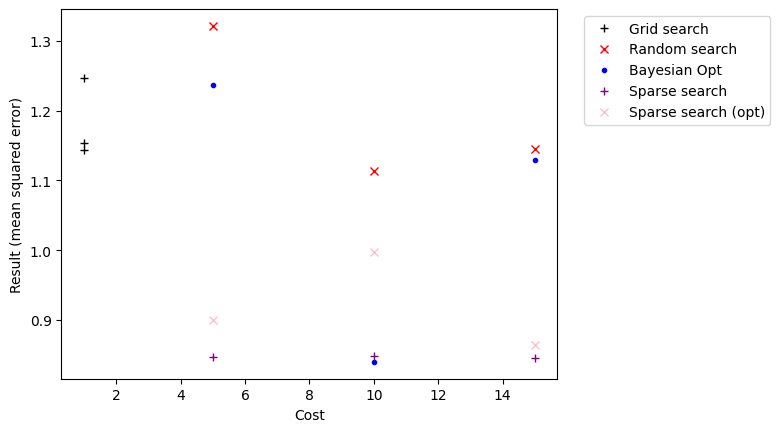

Current dataset: 1 with name id: 233211


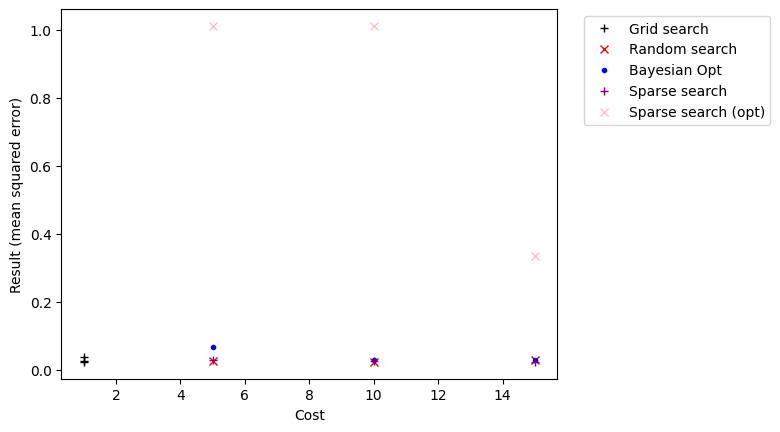

Current dataset: 2 with name id: 359935


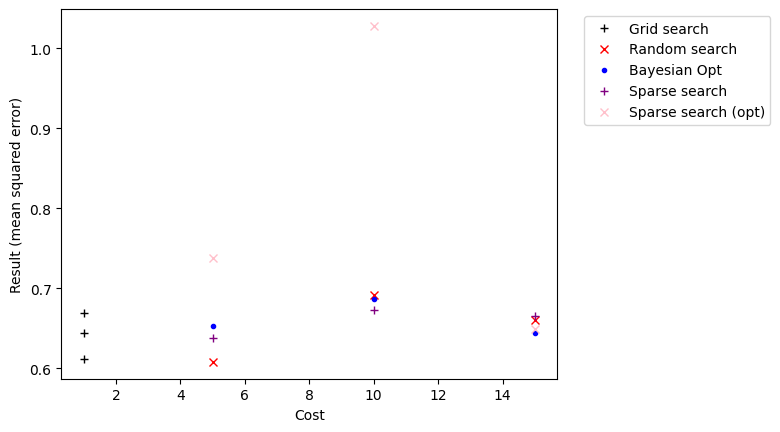

Current dataset: 3 with name id: 359952


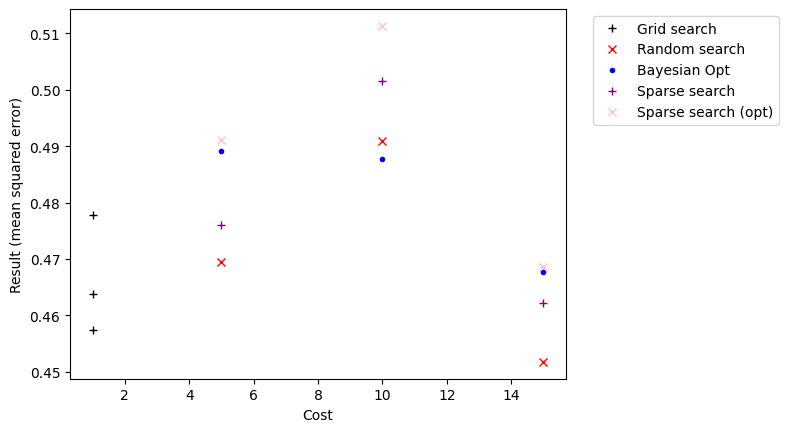

Current dataset: 4 with name id: 359940


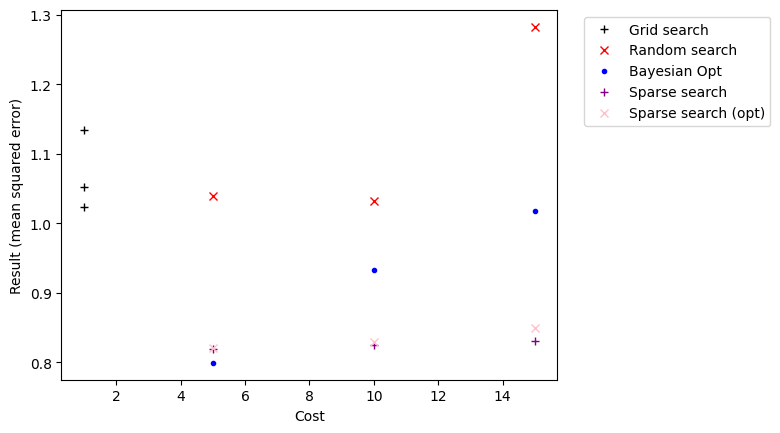

Current dataset: 5 with name id: 359931


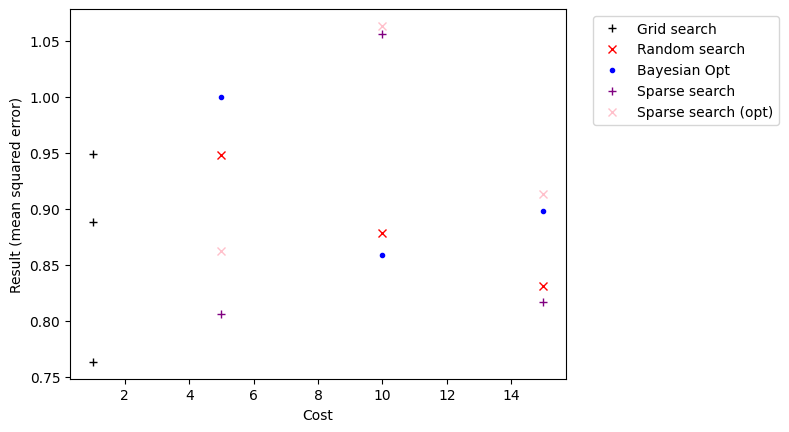

In [4]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

